In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
class PreProcessing:
    
    def __init__(self, X_scaler=None, nbins=32, 
                 orient=8, pix_per_cell=8, cell_per_block=2, 
                 conv='RGB2YCrCb', size=(32,32), window_size=64, cells_per_step=2,
                 heat_threshold = 1):
        self.conv = conv
        self.size = size
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.nbins = nbins
        self.X_scaler = X_scaler
        self.window_size = window_size
        self.cells_per_step = cells_per_step
        self.heat_threshold = heat_threshold
        
        
    def set_image(self, image, file=False, scale=True):
        if file:
            image = mpimg.imread(image)
        self.draw_img = image
        if scale:
            image = image.astype(np.float32)/255
        if self.conv != None:
            self.image = self.convert_color(image, self.conv)
        else:
            self.image = image
        self.ch1 = self.image[:,:,0]
        self.ch2 = self.image[:,:,1]
        self.ch3 = self.image[:,:,2]
        self.bboxes = []
        self.heatmap = np.zeros_like(self.draw_img[:,:,0]).astype(np.float)
        
        
    def convert_color(self, img, conv='RGB2YCrCb'):
        if conv == 'RGB2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if conv == 'BGR2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        if conv == 'RGB2LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        
        
    def get_bin_spatial(self, image=None):
        if image == None:
            ch1 = self.ch1
            ch2 = self.ch2
            ch3 = self.ch3
        else:
            ch1 = image[:,:,0]
            ch2 = image[:,:,1]
            ch3 = image[:,:,2]
        color1 = cv2.resize(ch1, self.size).ravel()
        color2 = cv2.resize(ch2, self.size).ravel()
        color3 = cv2.resize(ch3, self.size).ravel()
        return np.hstack((color1, color2, color3))
                
        
    def get_color_hist(self, image=None):    #bins_range=(0, 256)
        if image == None:
            ch1 = self.ch1
            ch2 = self.ch2
            ch3 = self.ch3
        else:
            ch1 = image[:,:,0]
            ch2 = image[:,:,1]
            ch3 = image[:,:,2]
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(ch1, bins=self.nbins)
        channel2_hist = np.histogram(ch2, bins=self.nbins)
        channel3_hist = np.histogram(ch3, bins=self.nbins)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    
    def get_hog_features(self, image, vis=False, feature_vec=True):
        if vis == True:
            features, hog_image = hog(image, orientations=self.orient, 
                                      pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                      cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        else:   
            features = hog(image, orientations=self.orient, 
                           pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                           cells_per_block=(self.cell_per_block, self.cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features 
        
        
    def get_all_hog_features(self, vis=False, feature_vec=True):
        if vis == True:            
            features_1, hog_image_1 = self.get_hog_features(self.ch1, vis, feature_vec)
            features_2, hog_image_2 = self.get_hog_features(self.ch2, vis, feature_vec)
            features_3, hog_image_3 = self.get_hog_features(self.ch3, vis, feature_vec)
            return np.hstack((features_1, features_2, features_3)), np.array([hog_image_1, hog_image_2, hog_image_3])
        else:      
            features_1 = self.get_hog_features(self.ch1, vis, feature_vec)
            features_2 = self.get_hog_features(self.ch2, vis, feature_vec)
            features_3 = self.get_hog_features(self.ch3, vis, feature_vec)
            self.hog = np.array([features_1, features_2, features_3])
            return np.hstack((features_1, features_2, features_3))
        
        
    def get_features_for_image(self, vis=False, feature_vec=True):
        hog_features = self.get_all_hog_features(vis, feature_vec)
        spatial_features = self.get_bin_spatial()
        hist_features = self.get_color_hist()
        
        if self.X_scaler == None:
            return np.hstack((spatial_features, hist_features, hog_features))
        else:
            return X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features))) 
        
        
    def get_features_for_window(self, vis=False, feature_vec=True):
        hog_features = self.get_all_hog_features(vis, feature_vec)
        spatial_features = self.get_bin_spatial()
        hist_features = self.get_color_hist()
        
        if self.X_scaler == None:
            return np.hstack((spatial_features, hist_features, hog_features))
        else:
            return X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features))) 
        
    
    def set_classifier(self, clf):
        self.clf = clf
    
    
    def find_cars(self, ystart, ystop, scale, return_boxes=False, return_predictions=False):
        if return_boxes:
            return_img = self.draw_img.copy()
        if return_predictions:
            return_pred_image = self.draw_img.copy()
        
        #scale image
        img_tosearch = self.image[ystart:ystop,:,:]
        imshape = img_tosearch.shape
        ctrans_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        hog1 = self.get_hog_features(ctrans_tosearch[:,:,0], feature_vec=False)
        hog2 = self.get_hog_features(ctrans_tosearch[:,:,1], feature_vec=False)
        hog3 = self.get_hog_features(ctrans_tosearch[:,:,2], feature_vec=False)
        
        #Define blocks and steps as above
        nxblocks = (ctrans_tosearch.shape[1] // self.pix_per_cell)-1
        nyblocks = (ctrans_tosearch.shape[0] // self.pix_per_cell)-1 
        nblocks_per_window = (self.window_size // self.pix_per_cell)-1 
        nxsteps = (nxblocks - nblocks_per_window) // self.cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // self.cells_per_step

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*self.cells_per_step
                xpos = xb*self.cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+self.window_size, xleft:xleft+self.window_size], (64,64))

                # Get color features
                spatial_features = self.get_bin_spatial(subimg)
                hist_features = self.get_color_hist(subimg)

                # Scale features and make a prediction
                all_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
                test_features = X_scaler.transform(all_features)   
                test_prediction = self.clf.predict(test_features)
                
                if return_boxes:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(self.window_size*scale)
                    cv2.rectangle(return_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(self.window_size*scale)
                    if return_predictions:
                        cv2.rectangle(return_pred_image,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                    self.bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
        if return_boxes:
            return return_img
        if return_predictions:
            return return_pred_image
                    
    def add_heat(self):
        for box in self.bboxes:
            self.heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        self.heatmap[self.heatmap <= self.heat_threshold] = 0
        self.labels = label(self.heatmap)
        
    
    def draw_labeled_bboxes(self):
        # Iterate through all detected cars
        for car_number in range(1, self.labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (self.labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(self.draw_img, bbox[0], bbox[1], (0,0,255), 6)
            
            
    def process_frame(self, image):
        p.set_image(image, scale=True)
        p.find_cars(400, 656, 1.5)
        p.add_heat()
        p.draw_labeled_bboxes()
        return self.draw_img
        
        
def get_images():
    car_images = glob.glob("./data/vehicles/**/*.png", recursive=True)
    non_car_images = glob.glob("./data/non-vehicles/**/*.png", recursive=True)
    return car_images, non_car_images

def get_train_test_data(car, non_car, preprocessor):
    car_features = []
    notcar_features = []
    print("Total Images: {}".format(len(car) + len(non_car)))
    i = 0
    for c in car:
        preprocessor.set_image(c, file=True, scale=False)
        car_features.append(preprocessor.get_features_for_image())
        i=i+1
    for nc in non_car:
        preprocessor.set_image(nc, file=True, scale=False)
        notcar_features.append(preprocessor.get_features_for_image())
        i=i+1

    X = np.vstack((car_features, notcar_features)).astype(np.float64)     
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test, X_scaler

## Hog

In [3]:
p = PreProcessing()
p.set_image("./data/vehicles/GTI_MiddleClose/image0000.png", file=True, scale=False)
car_image = p.draw_img
_, car_hog_image = p.get_all_hog_features(vis=True)
p.set_image("./data/non-vehicles/GTI/image1.png", file=True, scale=False)
non_car_image = p.draw_img
_, noncar_hog_image = p.get_all_hog_features(vis=True)

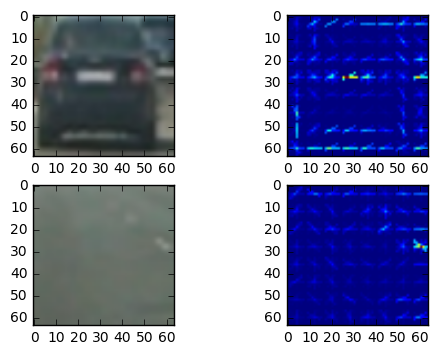

In [4]:
fig, axes = plt.subplots(2,2)
axes[0,0].imshow(car_image)
axes[0,1].imshow(car_hog_image[0])
axes[1,0].imshow(non_car_image)
axes[1,1].imshow(noncar_hog_image[0])
plt.savefig("./writeup_images/hog.png")

## Train Model

In [5]:
car, noncar = get_images()
p = PreProcessing()
X_train, X_test, y_train, y_test, X_scaler = get_train_test_data(car, noncar, p)

Total Images: 17760


In [6]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9921


## Sliding Window

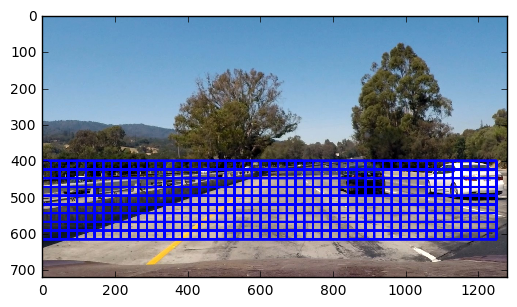

In [7]:
p = PreProcessing()
p.set_image("./test_images/test1.jpg", file=True, scale=True)
p.set_classifier(svc)
boxes = p.find_cars(400, 656, 1.5, True)
plt.imshow(boxes)
plt.savefig("./writeup_images/boxes.png")

## Prediction Boxes

In [8]:
p = PreProcessing()
p.set_image("./test_images/test1.jpg", file=True, scale=True)
p.set_classifier(svc)
pred_boxes_1 = p.find_cars(400, 656, 1.5, return_boxes=False, return_predictions=True)
p.set_image("./test_images/test2.jpg", file=True, scale=True)
pred_boxes_2 = p.find_cars(400, 656, 1.5, return_predictions=True)
p.set_image("./test_images/test3.jpg", file=True, scale=True)
pred_boxes_3 = p.find_cars(400, 656, 1.5, return_predictions=True)
p.set_image("./test_images/test4.jpg", file=True, scale=True)
pred_boxes_4 = p.find_cars(400, 656, 1.5, return_predictions=True)

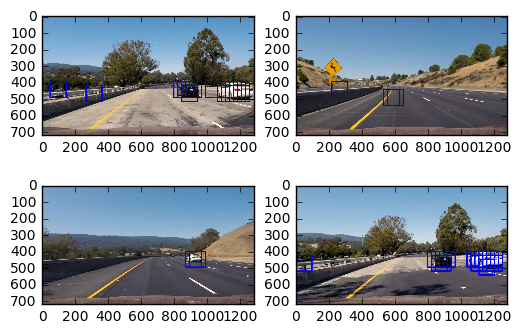

In [9]:
fig, axes = plt.subplots(2,2)
axes[0,0].imshow(pred_boxes_1)
axes[0,1].imshow(pred_boxes_2)
axes[1,0].imshow(pred_boxes_3)
axes[1,1].imshow(pred_boxes_4)
plt.savefig("./writeup_images/pred_boxes.png")

## Heat Map

In [10]:
p = PreProcessing()
p.set_image("./test_images/test1.jpg", file=True, scale=True)
p.set_classifier(svc)
pred_boxes_1 = p.find_cars(400, 656, 1.5, return_boxes=False, return_predictions=True)
p.add_heat()
p.draw_labeled_bboxes()

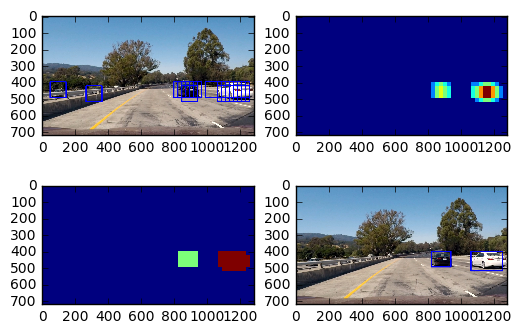

In [11]:
fig, axes = plt.subplots(2,2)
axes[0,0].imshow(pred_boxes_1)
axes[0,1].imshow(p.heatmap)
axes[1,0].imshow(p.labels[0])
axes[1,1].imshow(p.draw_img)
plt.savefig("./writeup_images/heat_map.png")

## Video

In [12]:
p = PreProcessing(X_scaler=X_scaler, window_size=64)
p.set_classifier(svc)

In [13]:
process_video = True
detection_output = 'project_video_detection.mp4'
if process_video:
    clip1 = VideoFileClip("project_video.mp4")
    detection_clip = clip1.fl_image(p.process_frame) #NOTE: this function expects color images!!
    %time detection_clip.write_videofile(detection_output, audio=False)

[MoviePy] >>>> Building video project_video_detection.mp4
[MoviePy] Writing video project_video_detection.mp4


100%|█████████▉| 1260/1261 [06:34<00:00,  3.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detection.mp4 

CPU times: user 25min 22s, sys: 44.4 s, total: 26min 6s
Wall time: 6min 34s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(detection_output))